# Autoencoder: the Basics

An autoencoder is a type of artificial neural network used to learn efficient data codings in an unsupervised manner. The aim of an autoencoder is to learn a representation (encoding) for a set of data, typically for dimensionality reduction, by training the network to ignore signal "noise". Along with the reduction side, a reconstructing side is learnt, where the autoencoder tries to generate from the reduced encoding a representation as close as possible to its original input, hence its name. -- from [Wikipedia](https://en.wikipedia.org/wiki/Autoencoder)

An autoencoder can be used for 

* feature analysis and dimensionality reduction
* denoising
* generating artificial contents (such as faces, musics, scenes)



![autoencoder.jpg](https://i.ibb.co/wL242Gy/vaee.png)


In this notebook, we will use an autoencoder in two different ways:

* **Semi-supervised**: train an autoencoder using images from one specific class in the `fashion-mnist` dataset; the trained autoencoder can then be used to decide whether an image belongs to this class based on the reconstruction error; the autoencoder can also be used to generate new images of that class by changing the *features* in the latent space (the bottleneck);

* **Unsupervised**: train an autoencoder using all images in `fashion-mnist` and cluster the images based on the features.

In [1]:
# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Reshape, Input

# check version
print('Using TensorFlow v%s' % tf.__version__)
acc_str = 'accuracy' if tf.__version__[:2] == '2.' else 'acc'

# k-means
from sklearn.cluster import KMeans
from sklearn import metrics

# helpers
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# widgets for dynamic controls
import ipywidgets as widgets

Using TensorFlow v2.3.1


---

# The Dataset

We start by loading the `fashion-mnist` dataset.

In [2]:
# load dataset
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# normalise images
train_images = train_images / 255.0
test_images = test_images / 255.0

# string labels
string_labels = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
                 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# print info
print("Number of training data: %d" % len(train_labels))
print("Number of test data: %d" % len(test_labels))
print("Image pixels: %s" % str(train_images[0].shape))
print("Number of classes: %d" % (np.max(train_labels) + 1))

Number of training data: 60000
Number of test data: 10000
Image pixels: (28, 28)
Number of classes: 10


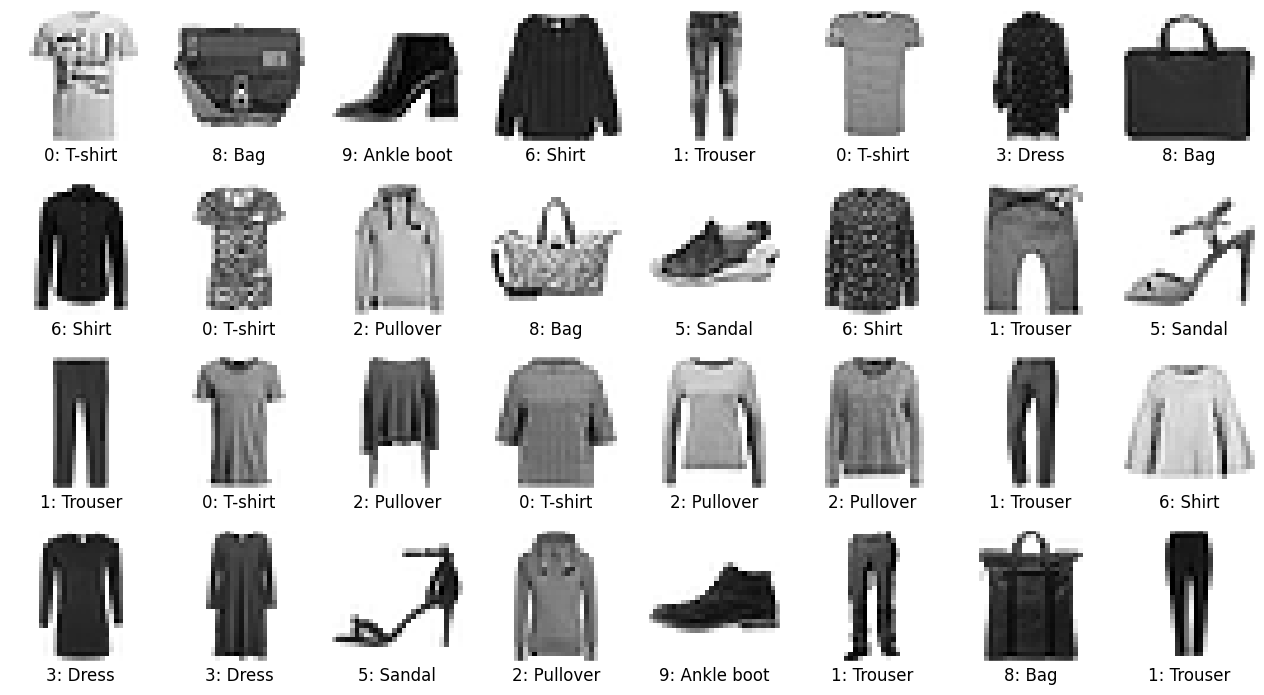

In [3]:
# function to plot an image in a subplot
def subplot_image(image, label, nrows=1, ncols=1, iplot=0, label2='', label2_color='r'):
    plt.subplot(nrows, ncols, iplot + 1)
    plt.imshow(image, cmap=plt.cm.binary)
    plt.xlabel(label, c='k', fontsize=12)
    plt.title(label2, c=label2_color, fontsize=12, y=-0.33)
    plt.xticks([])
    plt.yticks([])
    
# ramdomly plot some images and their labels
nrows = 4
ncols = 8
plt.figure(dpi=100, figsize=(ncols * 2, nrows * 2.2))
for iplot, idata in enumerate(np.random.choice(len(train_labels), nrows * ncols)):
    label = "%d: %s" % (train_labels[idata], string_labels[train_labels[idata]])
    subplot_image(train_images[idata], label, nrows, ncols, iplot)
plt.show()

---

# Semi-supervised

In this part, we will train an autoencoder using one specific class in `fashion-mnist`. The autoencoder will use the images from this class as **both the input and the output**. After training the autoencoder, we can feed in any image to decide whether it belongs to this class based on whether it can be well reconstructed by the autoencoder.

Such a strategy can be useful when 

* only one or a few classes in the dataset can be reliably labelled;
* no data in the dataset can be reliably labelled but we can generate synthetic data for some specific classes.

Besides, the autoencoder can be used to generate new images of that class by changing the **features** in the latent space (the bottleneck). 

## 1. Choose a target class

First, we choose a target class for training and extract the corresponding image subsets.

In [4]:
###############################
# choose a target class below #
###############################
# 'T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
# 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
target_class = 'Sneaker'

# get image subset of the chosen class
target_label = string_labels.index(target_class)
target_train_images = train_images[train_labels == target_label]
target_test_images = test_images[test_labels == target_label]
print('Number of images labelled "%s":' % (target_class,))
print('%d in training data' % (target_train_images.shape[0],))
print('%d in test data' % (target_test_images.shape[0],))

Number of images labelled "Sneaker":
6000 in training data
1000 in test data


## 2. Build and train the autoencoder

As shown in the opening figure, an autoencoder contains three parts:

* the encoder
* the bottleneck
* the decoder

Here we use three dense layers to implement these parts. The layers in the encoder and the decoder are reciprocal.

### Build the autoencoder

In [5]:
########################################
# specify the size of the latent space #
########################################
nfeature = 8

# build the network architecture
autoencoder = Sequential()

# encoder --------------------------------------------/
autoencoder.add(Flatten(input_shape=(28, 28)))
autoencoder.add(Dense(128, activation='relu'))
# ----------------------------------------------------/

# bottleneck -----------------------------------------/
autoencoder.add(Dense(nfeature))
# ----------------------------------------------------/

# decoder --------------------------------------------/
autoencoder.add(Dense(128, activation='relu'))
autoencoder.add(Dense(784, activation='sigmoid'))
autoencoder.add(Reshape((28, 28)))
# ----------------------------------------------------/

# print summary
autoencoder.summary()

# compile the model
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', 
                    metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 1032      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               1152      
_________________________________________________________________
dense_3 (Dense)              (None, 784)               101136    
_________________________________________________________________
reshape (Reshape)            (None, 28, 28)            0         
Total params: 203,800
Trainable params: 203,800
Non-trainable params: 0
__________________________________________________

### Train the autoencoder

**NOTE**: The input and output images are identical in this case.

In [6]:
# train the model
training_history = autoencoder.fit(target_train_images, target_train_images,
                                   epochs=100, batch_size=32,
                                   validation_data=(target_test_images, target_test_images))

Epoch 1/100
188/188 [==============================] - 1s 4ms/step - loss: 0.2738 - accuracy: 0.0566 - val_loss: 0.2213 - val_accuracy: 0.0590
Epoch 2/100
188/188 [==============================] - 1s 5ms/step - loss: 0.2141 - accuracy: 0.0581 - val_loss: 0.2060 - val_accuracy: 0.0586
Epoch 3/100
188/188 [==============================] - 1s 3ms/step - loss: 0.2029 - accuracy: 0.0652 - val_loss: 0.1993 - val_accuracy: 0.0668
Epoch 4/100
188/188 [==============================] - 1s 3ms/step - loss: 0.1969 - accuracy: 0.0737 - val_loss: 0.1952 - val_accuracy: 0.0712
Epoch 5/100
188/188 [==============================] - 1s 3ms/step - loss: 0.1942 - accuracy: 0.0760 - val_loss: 0.1937 - val_accuracy: 0.0755
Epoch 6/100
188/188 [==============================] - 1s 3ms/step - loss: 0.1930 - accuracy: 0.0826 - val_loss: 0.1929 - val_accuracy: 0.0814
Epoch 7/100
188/188 [==============================] - 1s 3ms/step - loss: 0.1922 - accuracy: 0.0868 - val_loss: 0.1922 - val_accuracy: 0.0934

Epoch 58/100
188/188 [==============================] - 0s 2ms/step - loss: 0.1865 - accuracy: 0.1455 - val_loss: 0.1881 - val_accuracy: 0.1436
Epoch 59/100
188/188 [==============================] - 0s 2ms/step - loss: 0.1866 - accuracy: 0.1464 - val_loss: 0.1881 - val_accuracy: 0.1502
Epoch 60/100
188/188 [==============================] - 0s 2ms/step - loss: 0.1865 - accuracy: 0.1476 - val_loss: 0.1881 - val_accuracy: 0.1405
Epoch 61/100
188/188 [==============================] - 0s 2ms/step - loss: 0.1864 - accuracy: 0.1462 - val_loss: 0.1882 - val_accuracy: 0.1429
Epoch 62/100
188/188 [==============================] - 0s 2ms/step - loss: 0.1865 - accuracy: 0.1456 - val_loss: 0.1881 - val_accuracy: 0.1437
Epoch 63/100
188/188 [==============================] - 0s 2ms/step - loss: 0.1864 - accuracy: 0.1476 - val_loss: 0.1881 - val_accuracy: 0.1444
Epoch 64/100
188/188 [==============================] - 0s 2ms/step - loss: 0.1864 - accuracy: 0.1469 - val_loss: 0.1881 - val_accuracy:

## 3. Reconstruction and decision

Next, we use our autoencoder to reconstruct all the test images and decide whether they belong to the target class based on the reconstruction error. Here we use the loss (computed by `model.evaluate()`) as the reconstruction error.

In [7]:
# reconstruct test images
test_images_reconstructed = autoencoder.predict(test_images)

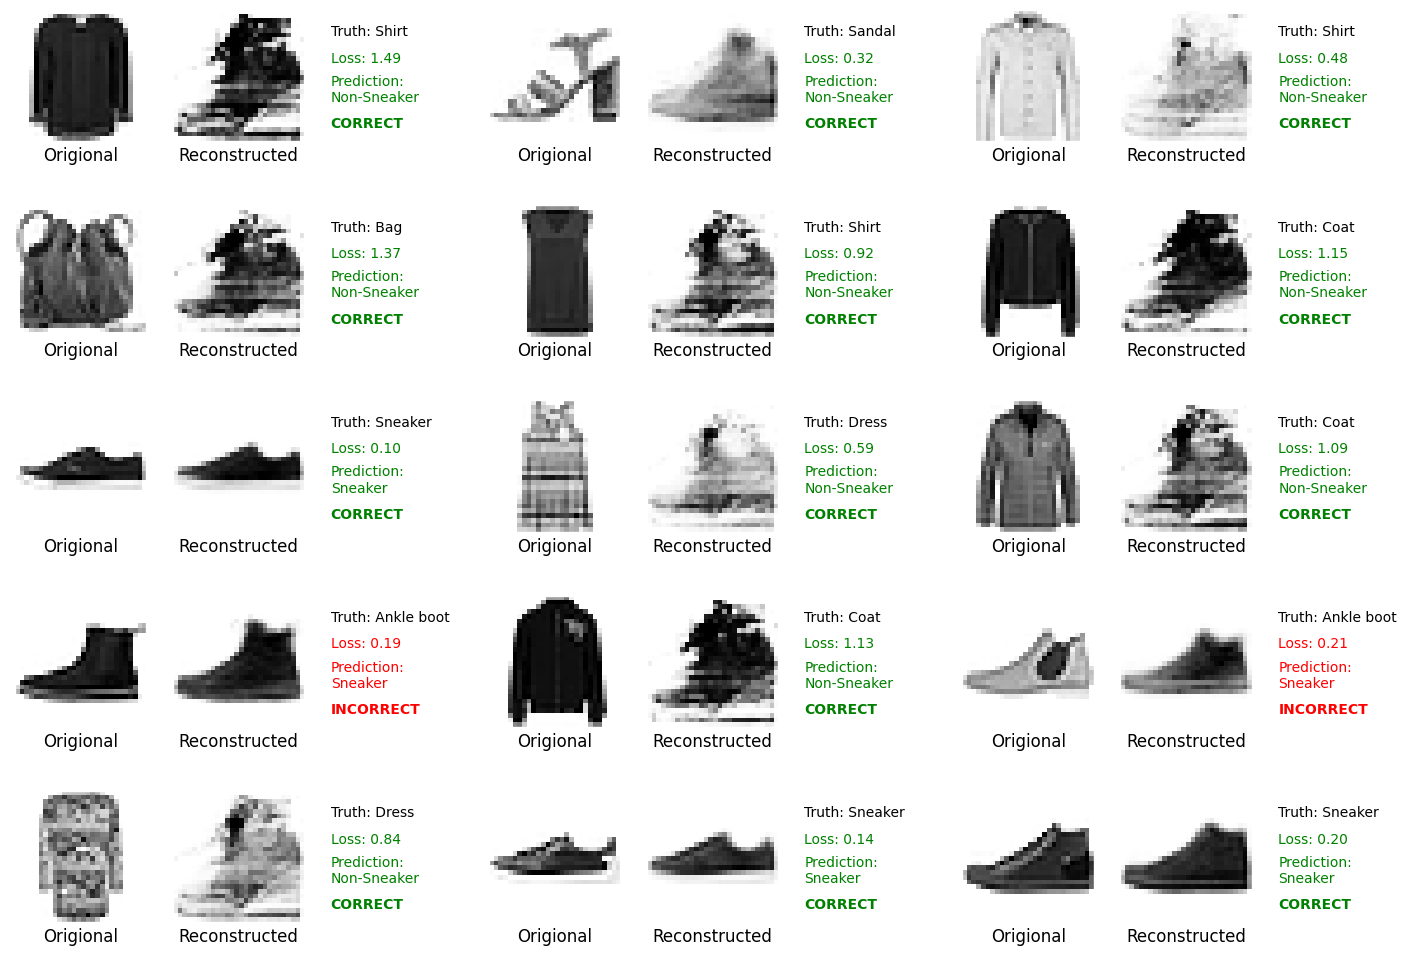

In [8]:
############################
# specify a threshold loss #
############################
# we suppose that an image should belong to the target class
# if the loss is smaller than this threshold
threshold_loss = 0.3

# randomly plot original and reconstructed images and decisions
nrows = 5
ncols = 3
plt.figure(dpi=100, figsize=(6 * ncols, 2.5 * nrows))
for iplot, itest in enumerate(np.random.choice(len(test_images), nrows * ncols)):
    # plot original and reconstructed images
    subplot_image(test_images[itest], 'Origional', nrows, ncols * 3, iplot * 3)
    subplot_image(test_images_reconstructed[itest], 'Reconstructed', nrows, ncols * 3, iplot * 3 + 1)
    
    # truth
    truth = (test_labels[itest] == target_label)
    # compute loss
    loss = autoencoder.evaluate(np.array([test_images[itest]]), 
                                np.array([test_images[itest]]), verbose=0)[0]
    # prediction
    pred = (loss < threshold_loss)
    # correct or not?
    correct = (truth == pred)
    
    # write information
    subplot_image([[0]], '', nrows, ncols * 3, iplot * 3 + 2)
    textcolor = 'g' if correct else 'r'
    plt.text(-.5, -.3, 'Truth: %s' % string_labels[test_labels[itest]], c='k')
    plt.text(-.5, -.1, 'Loss: %.2f' % loss, c=textcolor)
    plt.text(-.5, .2, 'Prediction:\n%s' % (target_class if pred else 'Non-%s' % target_class), c=textcolor)
    plt.text(-.5, .4, "CORRECT" if correct else 'INCORRECT', c=textcolor, weight='bold')
plt.show()

**NOTE**:
It is clear that the autoencoder tends to reshape every input image into the target class. This is why we can use the reconstruction error for decision.

## 4. Generate new images

We can also use the autoencoder to generate new images with the following steps:

1. encode an input image by the encoder;
2. change its features in the latent space;
3. decode the changed features to generate a new image.

### Extract encoder and decoder from autoencoder

We must first extract the encoding and decoding parts from the autoencoder.

In [9]:
# encoder
encoder = Sequential([
    autoencoder.layers[0],
    autoencoder.layers[1],
    autoencoder.layers[2]],
    name = 'encoder')
encoder.summary()
print('\n\n')

# decoder
decoder = Sequential([
    Input(shape=(nfeature,)),
    autoencoder.layers[-3],
    autoencoder.layers[-2],
    autoencoder.layers[-1]], 
    name='decoder')
decoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 1032      
Total params: 101,512
Trainable params: 101,512
Non-trainable params: 0
_________________________________________________________________



Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 128)               1152      
_________________________________________________________________
dense_3 (Dense)              (None, 784)               101136    
_________________________________

### Encode the images

In [10]:
# encode training images 
target_train_images_encoded = encoder.predict(target_train_images)

# reconstruct training images
target_train_images_reconstructed = autoencoder.predict(target_train_images)

# print the shapes
print('Shape of original: %s' % str(target_train_images.shape))
print('Shape of encoded: %s' % str(target_train_images_encoded.shape))
print('Shape of reconstructed: %s' % str(target_train_images_reconstructed.shape))

Shape of original: (6000, 28, 28)
Shape of encoded: (6000, 8)
Shape of reconstructed: (6000, 28, 28)


### Generate new images

In [11]:
# pick the index of the original image (0~5999)
image_index = 5999

# print original features
encoded_original = target_train_images_encoded[image_index]
print('The %d features in the latent space:' % nfeature)
print(list(encoded_original))

The 8 features in the latent space:
[2.513636, -2.5816147, -1.0278586, 0.48384568, -3.6739485, -3.009644, 4.0613637, 1.7007163]


In the following cell, we will implement a UI with slider controls so that we can dynamically change the features and see how the decoded image reacts to such changes.

In [12]:
# create sliders
sliders = []
argdict = {}
# slider range
smin = encoded_original.min() - (encoded_original.max() - encoded_original.min())
smax = encoded_original.max() + (encoded_original.max() - encoded_original.min())
for i in np.arange(nfeature):
    sliders.append(widgets.FloatSlider(min=smin, max=smax, step=.01, value=encoded_original[i], 
                                       description='Feature %d:' % (i + 1,),
                                       layout=widgets.Layout(width='auto', height='auto')))
    # associate sliders with varaibles passed to the respondent function
    argdict['v%d' % (i + 1)] = sliders[i]
ui = widgets.VBox(sliders)

# the UI-respondent function
# TODO: make argument count consistent with bottleneck size
def respond(v1, v2, v3, v4, v5, v6, v7, v8):
    ##### decoding happens here #####
    # decode
    encoded_modified = np.array([v1, v2, v3, v4, v5, v6, v7, v8])
    decoded_modified = decoder.predict(np.array([encoded_modified]))[0]
    # plot images
    plt.figure(dpi=100, figsize=(10, 3))
    subplot_image(target_train_images[image_index], 'Original', 1, 3, 0)
    subplot_image(target_train_images_reconstructed[image_index], 'Reconstructed original', 1, 3, 1)
    subplot_image(decoded_modified, 'Reconstructed modified', 1, 3, 2)
    plt.show()

# craete UI
out = widgets.interactive_output(respond, argdict)
display(ui, out)

Output()

## Exercises

* The size of the latent space, i.e., `nfeature` in the code, is the most critical network parameter. Try a smaller one (such as 4) and a larger one (such as 16) to see their influences.

* Implement the autoencoder using convolutional layers. For decoding, you can use `Conv2DTranspose` and `UpSampling2D` as the reciprocal layers of `Conv2D` and `MaxPool2D`, respectively.


---

# Unsupervised

In this part, we will use an autoencoder for unsupervised learning. We have learnt two clustering algorithms in [02_clustering_kmeans_GMM.ipynb](02_clustering_kmeans_GMM.ipynb), k-means and the Gaussian mixture method. Clustering algorithms are challenged by a large input dimensionality, such as 28 $\times$ 28 for `fashion-mnist`. To reduce the dimensionality, we can first train an autoencoder to encode the images and conduct clustering in the latent space.

## 1. Build and train the autoencoder

We use the same architecture as the previous one. The only difference is that we will use all the 10 classes for training.

In [13]:
########################################
# specify the size of the latent space #
########################################
nfeature_all = 8

# build the network architecture
autoencoder_all = Sequential()

# encoder --------------------------------------------/
autoencoder_all.add(Flatten(input_shape=(28, 28)))
autoencoder_all.add(Dense(128, activation='relu'))
# ----------------------------------------------------/

# bottleneck -----------------------------------------/
autoencoder_all.add(Dense(nfeature_all))
# ----------------------------------------------------/

# decoder --------------------------------------------/
autoencoder_all.add(Dense(128, activation='relu'))
autoencoder_all.add(Dense(784, activation='sigmoid'))
autoencoder_all.add(Reshape((28, 28)))
# ----------------------------------------------------/

# print summary
autoencoder_all.summary()

# compile the model
autoencoder_all.compile(optimizer='adam', loss='binary_crossentropy', 
                        metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 1032      
_________________________________________________________________
dense_6 (Dense)              (None, 128)               1152      
_________________________________________________________________
dense_7 (Dense)              (None, 784)               101136    
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28)            0         
Total params: 203,800
Trainable params: 203,800
Non-trainable params: 0
________________________________________________

In [14]:
# train the model with all the 10 classes
training_history_all = autoencoder_all.fit(train_images, train_images,
                                           epochs=50, batch_size=32,
                                           validation_data=(test_images, test_images))

Epoch 1/50
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3188 - accuracy: 0.0982 - val_loss: 0.2994 - val_accuracy: 0.1165
Epoch 2/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2945 - accuracy: 0.1219 - val_loss: 0.2944 - val_accuracy: 0.1234
Epoch 3/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2909 - accuracy: 0.1332 - val_loss: 0.2921 - val_accuracy: 0.1390
Epoch 4/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2891 - accuracy: 0.1412 - val_loss: 0.2909 - val_accuracy: 0.1403
Epoch 5/50
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2880 - accuracy: 0.1460 - val_loss: 0.2897 - val_accuracy: 0.1520
Epoch 6/50
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2872 - accuracy: 0.1494 - val_loss: 0.2892 - val_accuracy: 0.1515
Epoch 7/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2867 - accuracy: 0.1534 - val_loss: 0.2888 - val_accuracy:

## 2. Encode the images

Extract the encoder from the autoencoder and use it to encode the images

In [15]:
# extract encoder
encoder_all = Sequential([
    autoencoder_all.layers[0],
    autoencoder_all.layers[1],
    autoencoder_all.layers[2]])
encoder_all.summary()

# encode images
train_images_encoded = encoder_all.predict(train_images)
print('\n* Shape of the encoded images: %s' % str(train_images_encoded.shape))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 1032      
Total params: 101,512
Trainable params: 101,512
Non-trainable params: 0
_________________________________________________________________

* Shape of the encoded images: (60000, 8)


## 3. Cluster the encoded  images

Now we can use k-means to cluster the encoded images. Note that the number of clusters does not have to be the number of the original classes (10). Here we will use 20 to relax the constraints for k-means.

In [16]:
# build k-means
n_clusters = 20
kmeans_model = KMeans(n_clusters=n_clusters, max_iter=500)

# train and predict
kmeans_labels = kmeans_model.fit_predict(train_images_encoded)

# print scores
print('Homogeneity score = %.3f' % metrics.homogeneity_score(train_labels, kmeans_labels))
print('Completeness score = %.3f' % metrics.completeness_score(train_labels, kmeans_labels))
print('V-measure score = %.3f' % metrics.v_measure_score(train_labels, kmeans_labels))

Homogeneity score = 0.655
Completeness score = 0.512
V-measure score = 0.575


Further, we can plot a few images in each cluster to get a sense of the quality of clustering:

* It is shown that some similar-looking classes such as "T-shirts", "Shirts", "Coats" and "Pullovers" are not well resolved, which implies that we may need a larger latent space in the autoencoder. 

* Also, it is interesting that some classes are clustered into sub-classes, such as "Bags" into the ones with and without handles and the clothes into dark- and light-coloured ones; this explains why we need more than 10 clusters for k-means.



Images in Cluster 0:


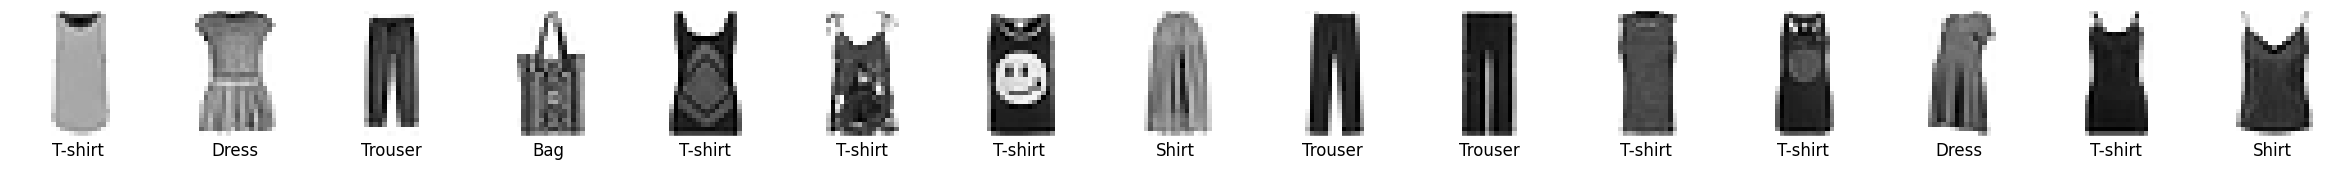



Images in Cluster 1:


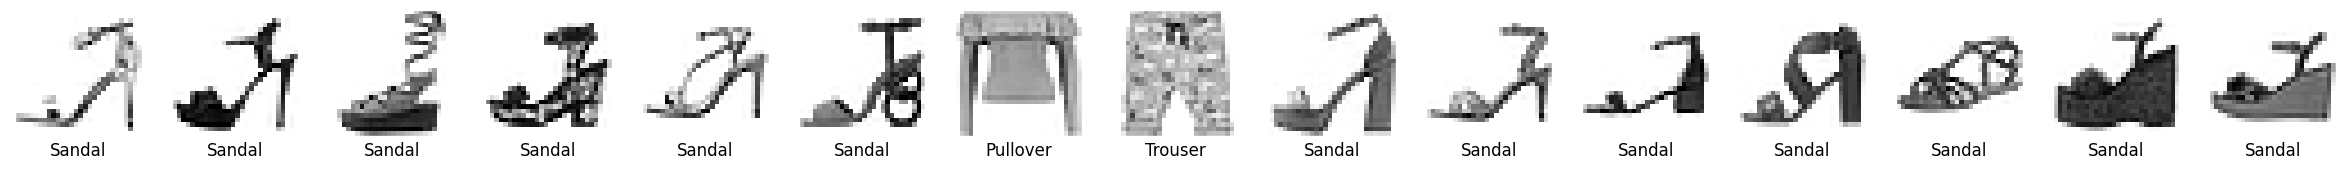



Images in Cluster 2:


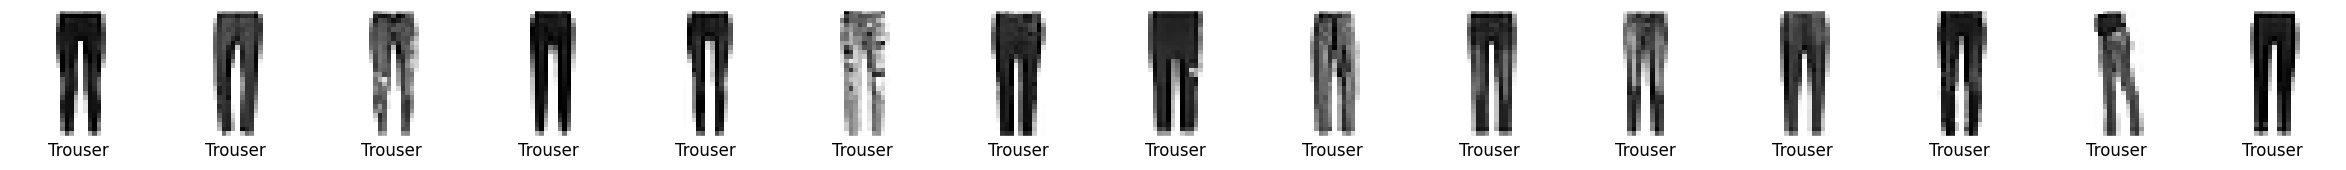



Images in Cluster 3:


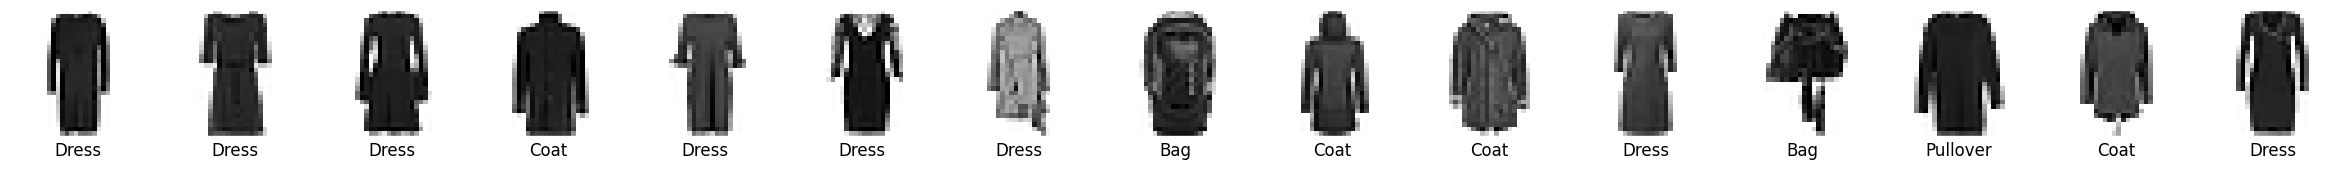



Images in Cluster 4:


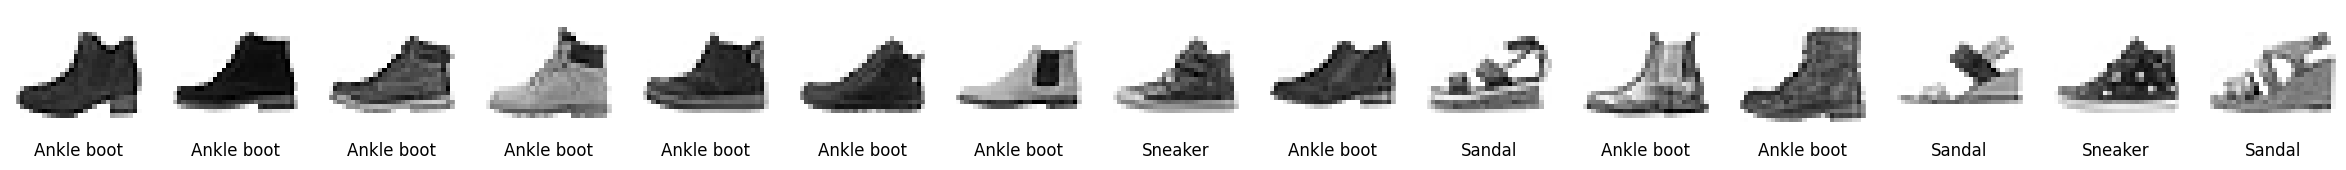



Images in Cluster 5:


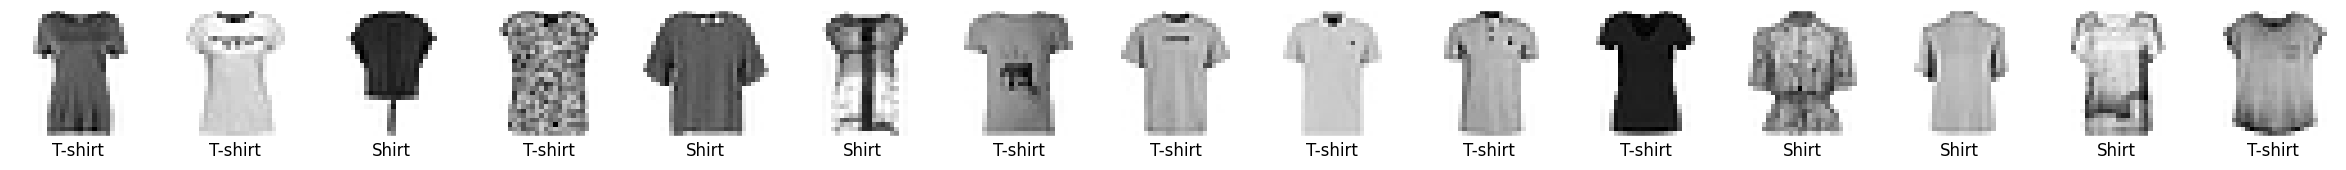



Images in Cluster 6:


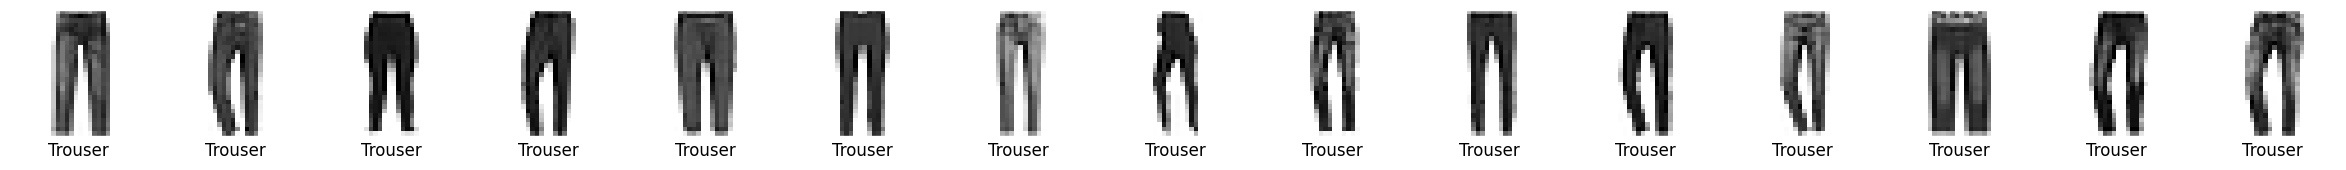



Images in Cluster 7:


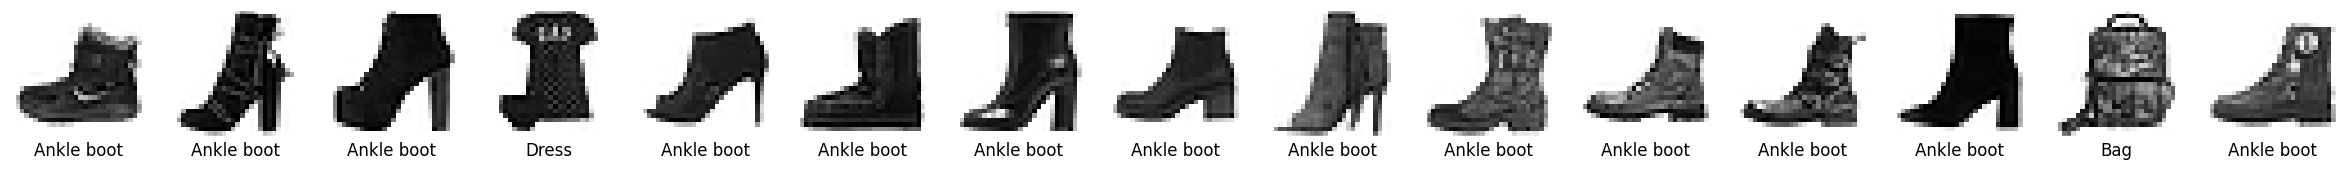



Images in Cluster 8:


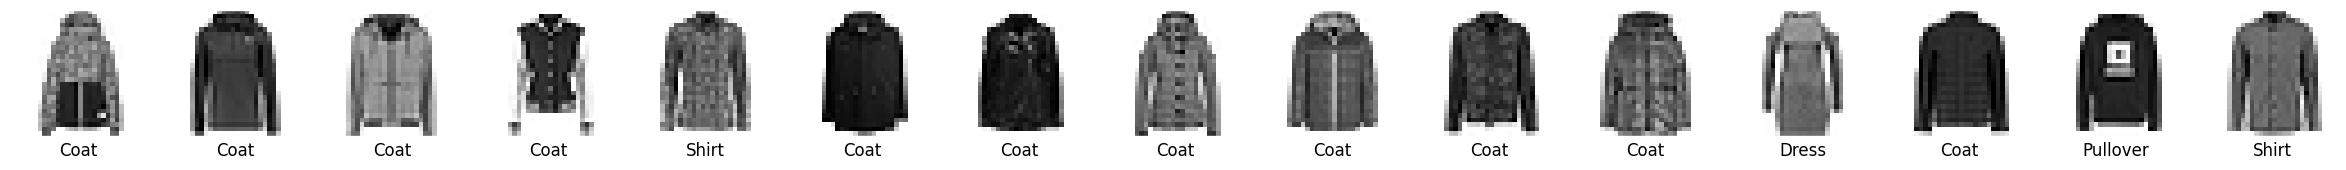



Images in Cluster 9:


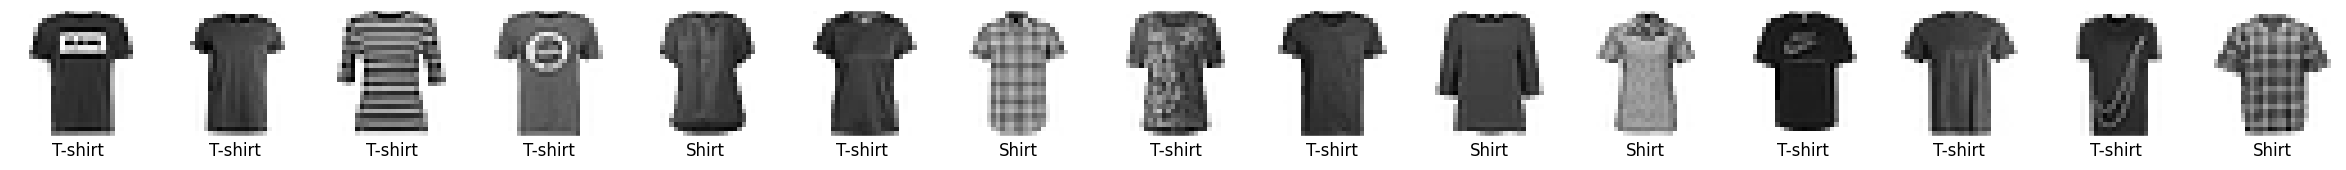



Images in Cluster 10:


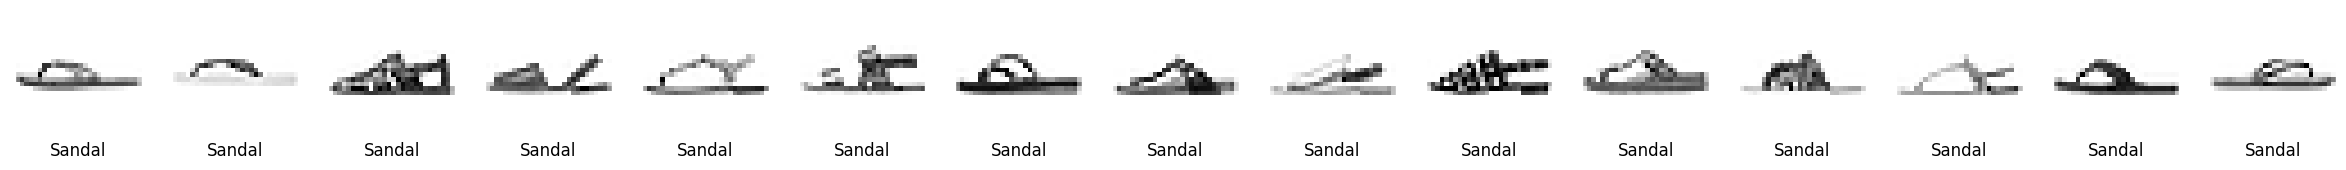



Images in Cluster 11:


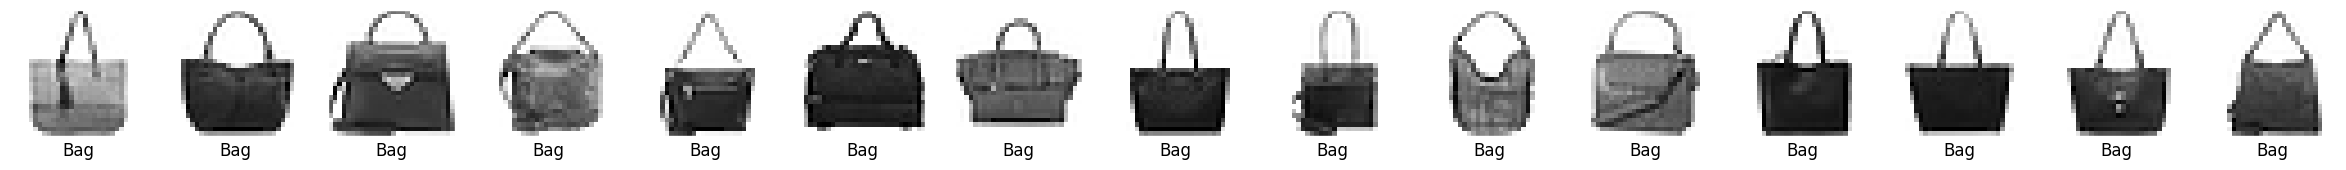



Images in Cluster 12:


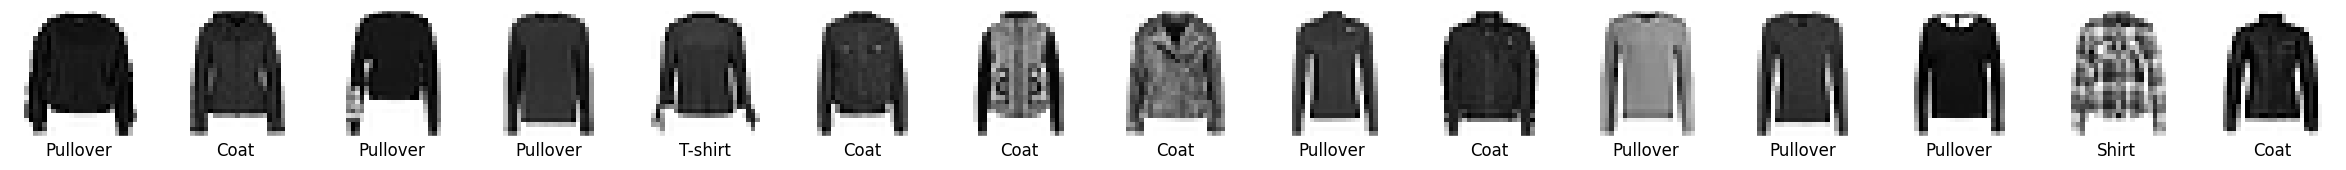



Images in Cluster 13:


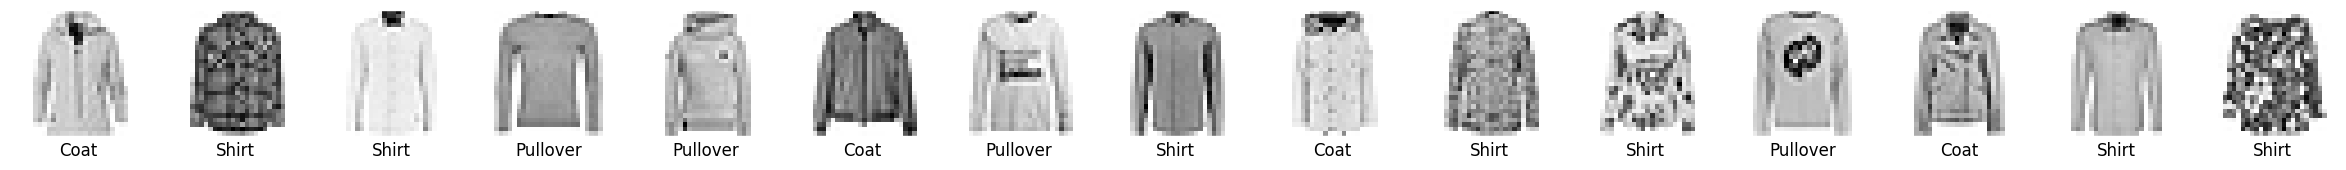



Images in Cluster 14:


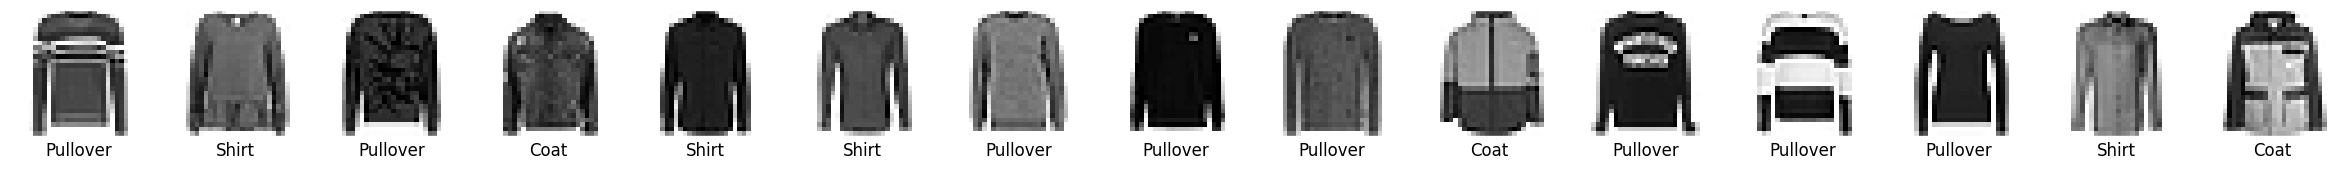



Images in Cluster 15:


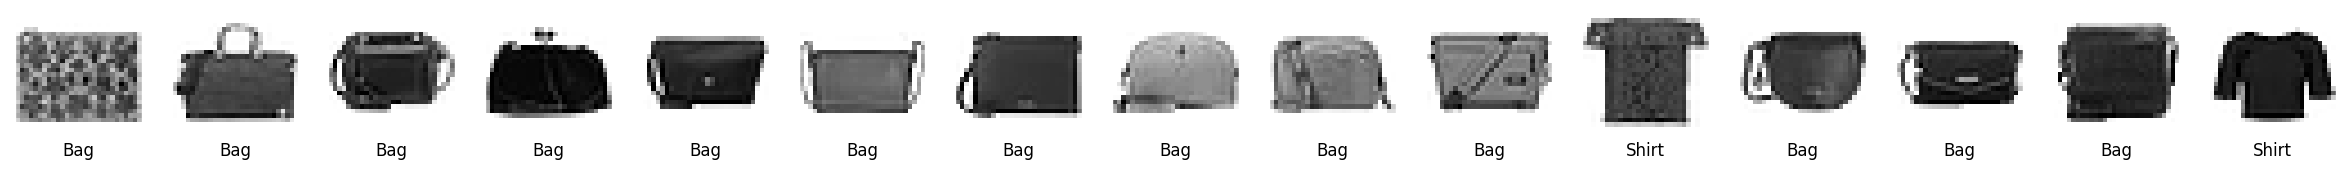



Images in Cluster 16:


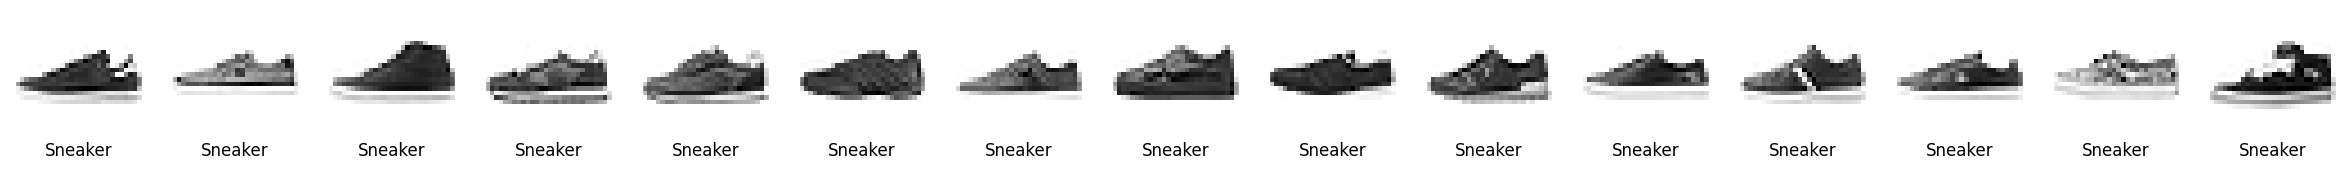



Images in Cluster 17:


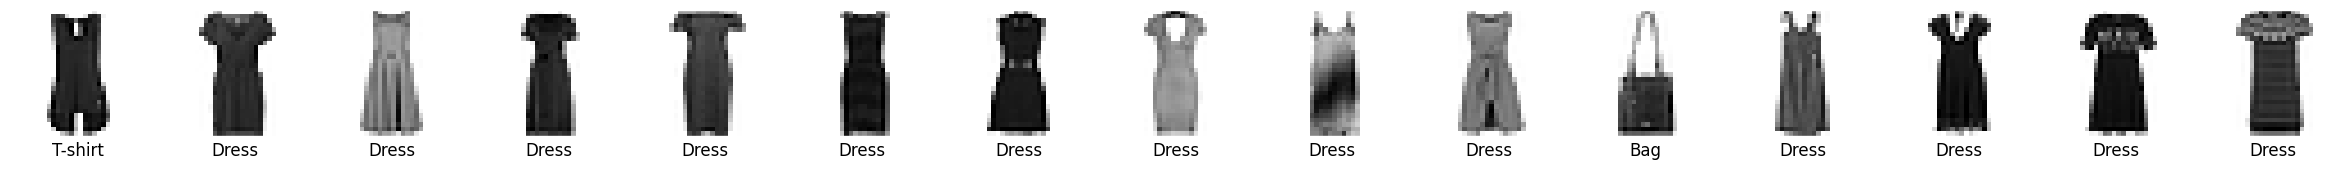



Images in Cluster 18:


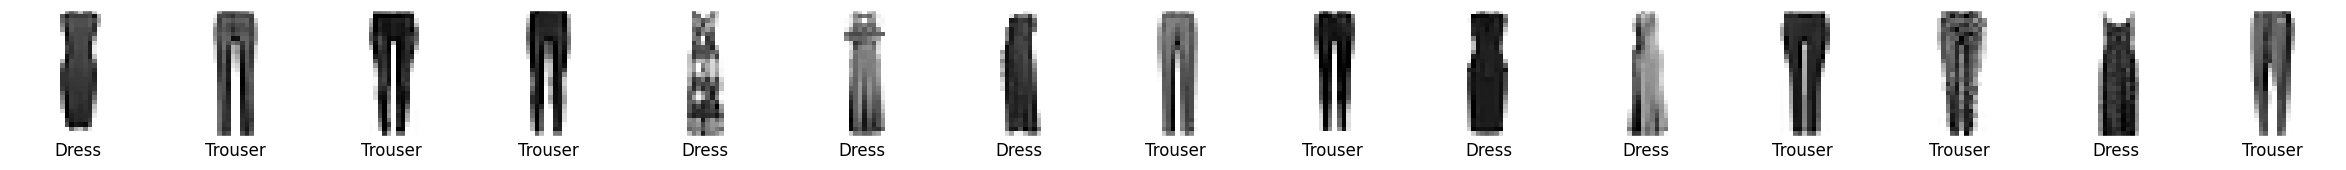



Images in Cluster 19:


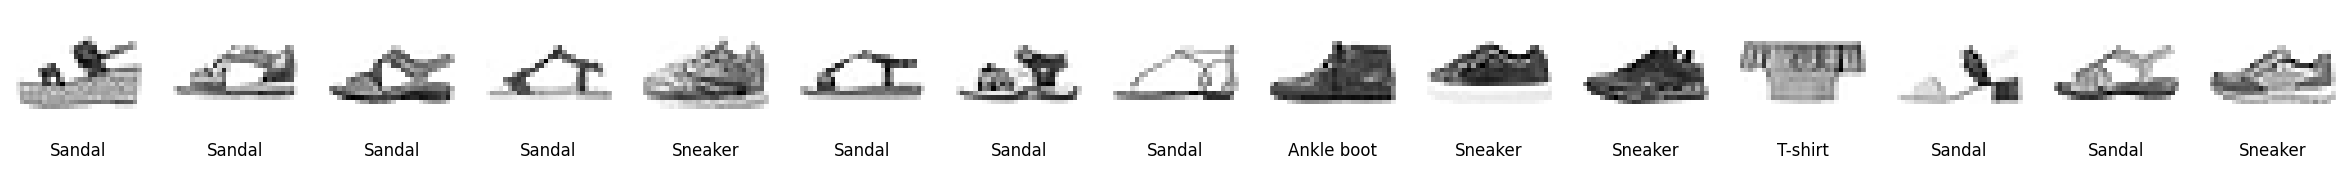

In [17]:
n_image_per_cluster = 15
for cluster_label in np.arange(n_clusters):
    # get indices of the first n_image_per_cluster in this cluster
    itrains = np.where(kmeans_labels == cluster_label)[0][0:n_image_per_cluster]
    print('\n\nImages in Cluster %d:' % cluster_label)
    fig = plt.figure(dpi=100, figsize=(n_image_per_cluster * 2, n_clusters * 2))
    for iplot, itrain in enumerate(itrains):
        subplot_image(train_images[itrain], string_labels[train_labels[itrain]], 
                      n_clusters, n_image_per_cluster, iplot)
    plt.show()

### Visualise clustering in the latent space

Finally, we can visualise the clustering results in the latent space. These plots can manifest which features in the latent space are dominating the formation of certain clusters. 

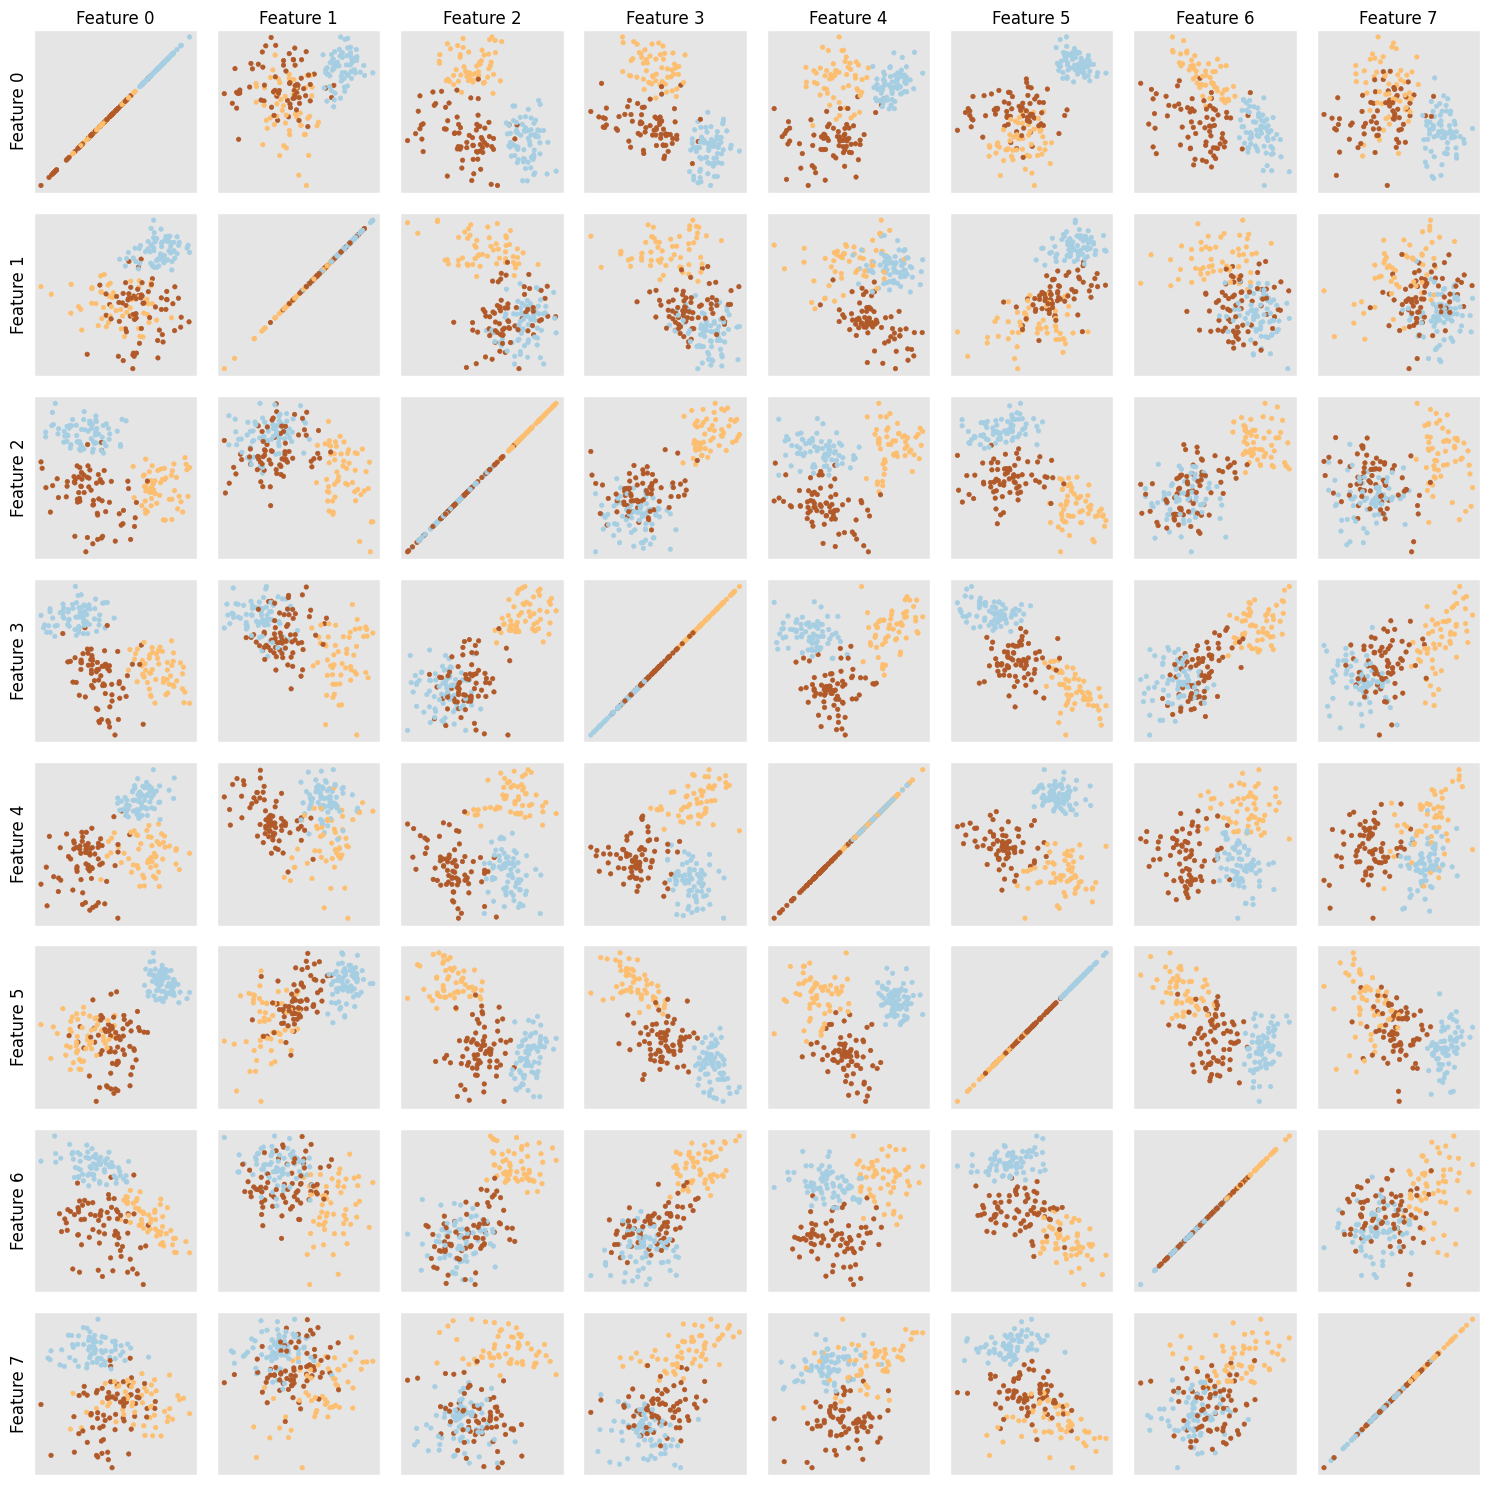

In [18]:
# specify total number of data points to show
show_ndata = 200

# specify the clusters to show
# showing all 20 clusters will make the figures unreadable; just select a few
show_clusters = np.array([1, 2, 3])

# find the data subset
show_data_indices = np.where(np.isin(kmeans_labels, show_clusters))[0][0:show_ndata]

# normalise features to [0, 1]
train_images_encoded_norm = (train_images_encoded - train_images_encoded.min()) / \
                            (train_images_encoded.max() - train_images_encoded.min())
# for better visualisation
train_images_encoded_norm = np.power(train_images_encoded_norm, .5)

# plot
plt.figure(dpi=100, figsize=(15, 15))
iplot = 0
for feature_x in np.arange(nfeature_all):
    for feature_y in np.arange(nfeature_all):
        plt.subplot(nfeature_all, nfeature_all, iplot + 1)
        x = train_images_encoded_norm[show_data_indices, feature_x]
        y = train_images_encoded_norm[show_data_indices, feature_y]
        plt.scatter(x, y, c=kmeans_labels[show_data_indices], s=10, cmap=plt.cm.Paired)
        plt.xticks([])
        plt.yticks([])
        iplot += 1
        if feature_y == 0:
            plt.ylabel('Feature %d' % feature_x, c='k')
        if feature_x == 0:
            plt.gca().xaxis.set_label_position('top') 
            plt.xlabel('Feature %d' % feature_y, c='k')
plt.tight_layout()
plt.show()

---

## Exercises

Try to increase the quality of clustering by using
1. a larger latent space in the autoencoder
2. convolutional layers for encoding and decoding
3. GMM for clustering the encodings